In [1]:
#!/usr/bin/env python
import argparse
import textwrap
import numpy as np
import os
from wmf import wmf
import alarmas as al
from multiprocessing import Pool
import glob
import pylab as pl 
import warnings
warnings.filterwarnings('ignore')
% matplotlib inline

#Parametros de entrada del trazador
parser=argparse.ArgumentParser(
	prog='Genera_Grafica_SlidesSim',
	formatter_class=argparse.RawDescriptionHelpFormatter,
	description=textwrap.dedent('''\
	Genera los mapas de deslizamientos simulados por las parametrizaciones
	del modelo hidrologico.
        '''))
#Parametros obligatorios
parser.add_argument("date",help="(Obligatorio) Decha actual de ejecucion YYYY-MM-DD-HH:MM")
parser.add_argument("cuenca",help="Cuenca con la estructura que hace todo")
parser.add_argument("rutaConfig",help="(Obligatorio) Ruta con la configuracion de la cuenca")
parser.add_argument("-c", "--coord",help="Escribe archivo con coordenadas", default = False, type = bool)
parser.add_argument("-v","--verbose",help="Informa sobre la fecha que esta agregando", 
	action = 'store_true')
	
#lee todos los argumentos
args=parser.parse_args()

In [9]:
date='2017-10-09'
cuenca='/media/nicolas/Home/Jupyter/Soraya/Op_Alarmas/Op_AMVA60m/01_Cuenca/Barbosa_Slides_001.nc'
rutaConfig='/media/nicolas/Home/Jupyter/Soraya/Op_Alarmas/Op_AMVA60m/01_Cuenca/EjemploCalib_Calib.md'
coord=True
verbose=True

In [10]:
#-------------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------
#Lectura de cuenca y variables
cu = wmf.SimuBasin(rute=cuenca, SimSlides = True)
wmf.models.slide_allocate(cu.ncells, 10)

In [11]:
#Se marcan con 1 las celdas incondicionalmente inestables.
R = np.copy(wmf.models.sl_riskvector)

In [12]:
R1 = np.zeros(cu.ncells)
pos_ever=np.where(R==2)[1]
R1[pos_ever] = 1

In [13]:
#Lee el archivo de configuracion
ListConfig = al.get_rutesList(rutaConfig)
#Se define ruta donde se leeran los resultados a plotear
ruta_in = al.get_ruta(ListConfig,'ruta_slides')
#Lectura de rutas de salida de la imagen
ruta_out = al.get_ruta(ListConfig,'ruta_map_slides')
#Diccionario con info de plot: se lee la info de todos los parametrizaciones
ListPlotVar = al.get_modelConfig_lines(ListConfig, '-p', Calib_Storage='Plot',PlotType='Slides')

#Construye las listas para plotear en paralelo para cada parametrizacion
#Ademas se acumula el numero de celdas acumuladas de todas las parametrizaciones.
ListaEjec = []; Vsum = np.zeros(cu.ncells)

In [14]:
for l in range(0,len(ListPlotVar)):
	#Mira la ruta del folder y si no existe la crea
	ruta_folder = ruta_out+ListPlotVar[l]+'/'
	Esta = glob.glob(ruta_folder)
	if len(Esta) == 0:
		os.system('mkdir '+ruta_folder)
	#Obtiene las rutas de los archivos de salida
	ruta_out_png = ruta_folder+'Slides'+ListPlotVar[l]+'_'+date+'.png'
	ruta_out_txt = ruta_folder+'Slides'+ListPlotVar[l]+'_'+date+'.txt'
	#Lee los binarios de deslizamientos para la cuenca, para cada parametrizacion
	v,r = wmf.models.read_int_basin(ruta_in,l+1,cu.ncells)
    #Se marcan las celdas simuladas con 2.
	#Si no hay celdas simuladas, deslizamos una para no alterar la escala de colores.
	if v.max()==0:
		v[0]=2
	else:
		v[v==1]=2
	#se suman las celdas siempre inestables con las simuladas
	map1 = R1 + v
	# se  sesga el max a 2 para que se vean bien las celdas simuladas
	map1[map1>2] = 2
	#Se organiza la lista con parametros necesarios para plotear los mapas con la funcion que sigue
	ListaEjec.append([ruta_in, ruta_out_png, ruta_out_txt, map1, ListPlotVar[l]])
	#Se van acumulando las celdas simuladas en cada parametrizacion
	Vsum += v
#Si marcan las celdas siempre inestables y se sesga a 2 las celdas mayores que 2 para no alterar escala de color.
Vsum[pos_ever]=1
Vsum[Vsum>2]=2
#si no hay celdas deslizadas, deslizamos una para no alterar la escala de colores.
if Vsum.max()==1:
	Vsum[0]=2
else:
	pass

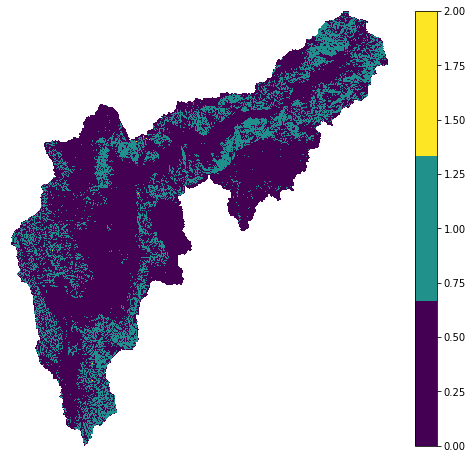

([-75.71027374267578,
  -75.215234393777791,
  5.978703498840332,
  6.5508705253014341],
 <matplotlib.axes._subplots.AxesSubplot at 0x7f83b4255450>)

In [15]:
cu.Plot_basinClean(map1,cmap = pl.get_cmap('viridis',3),show_cbar=True)

In [ ]:
###Se agrega el mapa de celdas acumuladas entre los que se van a plotear desde la info en ListaEjec
#Obtiene las rutas de los archivos de salida
	#Mira la ruta del folder y si no existe la crea
	ruta_folder = ruta_out+'ParsAcum/'
	Esta = glob.glob(ruta_folder)
	if len(Esta) == 0:
		os.system('mkdir '+ruta_folder)
ruta_out_png = ruta_folder+'SlidesParsAcum_'+date+'.png'
ruta_out_txt = ruta_folder+'SlidesParsAcum_'+date+'.txt'
#Se organiza la lista con parametros necesarios para plotear los mapas con la funcion que sigue
ListaEjec.append([ruta_in, ruta_out_png, ruta_out_txt, Vsum, '999'])

In [ ]:
#-------------------------------------------------------------------------------------------------------
#Se generan  los plots de deslizamientos de cada parametrizacion y el acumulado
#-------------------------------------------------------------------------------------------------------

def Plot_SlidesSim(Lista):
	# #Plots de Parametrizaciones
	# bins=4
	# try:
	# 	ticks_vec=np.arange(0,VarToPlot.max()+1,int(VarToPlot.max())/bins)
	# except:
	# 	ticks_vec=np.arange(0,3.5,0.5)
    
	VarToPlot=Lista[-2]
	if Lista[-1] != '999':
		Coord,ax=cu.Plot_basinClean(VarToPlot,#show_cbar=True,
									ruta=Lista[1],
									cmap = pl.get_cmap('viridis',3),
									show=False,figsize = (30,15))                                    
								#se configura los ticks del colorbar para que aparezcan siempre la misma cantidad y del mismo tamano
								# cbar_ticks=ticks_vec,cbar_ticklabels=ticks_vec,cbar_ticksize=16,									
		#ax.set_title('Slides Map Par'+Lista[-1]+' '+args.date, fontsize=16 )
		#~ pl.suptitle('Slides Map Par'+Lista[-1]+' '+args.date, fontsize=18, x=0.5, y=0.09)		
		#~ ax.figure.savefig(Lista[1],bbox_inches='tight')
	#Plot de mapa acumulado de deslizamientos en todas las Parametrizaciones
	else:
		Coord,ax=cu.Plot_basinClean(VarToPlot,#show_cbar=True,
									cmap = pl.get_cmap('viridis',3),
									ruta=Lista[1],
									show=False,figsize = (30,15))                                    
							#se configura los ticks del colorbar para que aparezcan siempre la misma cantidad y del mismo tamano
							#~ cbar_ticks=ticks_vec,cbar_ticklabels=ticks_vec,cbar_ticksize=16,
		#ax.set_title('Slides Map AcumPars '+args.date, fontsize=16 )
		#~ pl.suptitle('Slides Map AcumPars '+args.date, fontsize=18, x=0.5, y=0.09)
		#~ ax.figure.savefig(Lista[1],bbox_inches='tight')
        
	#dice lo que hace
	if args.verbose:
		print 'Aviso: Plot de Deslizamientos para '+Lista[-1]+' generado.'

In [ ]:
#Ejecuta los plots
if len(ListaEjec) > 15:
	Nprocess = 15
else:
	Nprocess = len(ListaEjec)
p = Pool(processes = Nprocess)
p.map(Plot_SlidesSim, ListaEjec)
p.close()

#Guarda archuivo con coordenadas - por defecto es false, cuando se cambie revisar Coord.
if args.coord:
	f = open(ListaEjec[0][2], 'w')
	for t,i in zip(['Left', 'Right', 'Bottom', 'Top'], Coord):
		f.write('%s, \t %.4f \n' % (t,i))
	f.close()